# Predicting K - In Depth Analysis with SHAP
This notebook is a companion to the paper Deciphering the variability in air-sea gas transfer due to sea state and wind history

Written by David Moffat dmof@pml.ac.uk 2024-06-04



In [1]:
# !pip install shap
# import shap

In [2]:
%matplotlib inline

import glob, os, math, pathlib
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.ensemble
import sklearn.feature_selection
import matplotlib.pyplot as plt
import matplotlib as mpl

# # Bad Practice - but remove all warnings for now.
# import warnings
# warnings.filterwarnings("ignore")

fig_dir = 'new_figs'
pathlib.Path(fig_dir).mkdir(parents=True, exist_ok=True)

seed = 950

## Read In Data
Read in the data and merge into a single dataset, adding the cruise name as a variable and dropping all rows where k is `NaN`. We set the predictors and prediction variables, and investigate the dataset.

In [3]:
!rm -rf "Reevaluated flux data"
!curl -o training_data.zip https://www.frontiersin.org/articles/file/downloadfile/826421_supplementary-materials_datasheets_1_zip/octet-stream/Data%20Sheet%201.ZIP/1/826421?isPublishedV2=False
!unzip training_data.zip
!rm -rf __MACOSX

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  496k  100  496k    0     0  1202k      0 --:--:-- --:--:-- --:--:-- 1200k
Archive:  training_data.zip
   creating: Reevaluated flux data/
  inflating: Reevaluated flux data/SOAP_table_long.txt  
   creating: __MACOSX/
   creating: __MACOSX/Reevaluated flux data/
  inflating: __MACOSX/Reevaluated flux data/._SOAP_table_long.txt  
  inflating: Reevaluated flux data/ANDREXII_table_long.txt  
  inflating: __MACOSX/Reevaluated flux data/._ANDREXII_table_long.txt  
  inflating: Reevaluated flux data/JR18007_table_long.txt  
  inflating: __MACOSX/Reevaluated flux data/._JR18007_table_long.txt  
  inflating: Reevaluated flux data/HiWinGS_table_long.txt  
  inflating: __MACOSX/Reevaluated flux data/._HiWinGS_table_long.txt  
  inflating: Reevaluated flux data/Knorr11_table_long.txt  
  inflating: __MACOSX/Reevaluated flux data/._Knorr

In [4]:
file_list = glob.glob('Reevaluated flux data/*')
file_list

['Reevaluated flux data/SOAP_table_long.txt',
 'Reevaluated flux data/SO_234_235_table_long.txt',
 'Reevaluated flux data/Knorr07_table_long.txt',
 'Reevaluated flux data/JR18007_table_long.txt',
 'Reevaluated flux data/HiWinGS_table_long.txt',
 'Reevaluated flux data/NBP_1210_1402_table_long.txt',
 'Reevaluated flux data/ANDREXII_table_long.txt',
 'Reevaluated flux data/Knorr11_table_long.txt']

In [5]:
df_list = []
for file_load in file_list:
#     print(file_load[5:-15])
    df_ = pd.read_csv(file_load,
                     parse_dates=[0],
                     skiprows=range(36),
                     sep='\t',
                     )
    df_.dropna(subset=['kCO2660_cm_hr'], inplace=True)
    df_['Cruise'] = file_load.split('/')[-1][:-15]
    df_list.append(df_)

df = pd.concat(df_list, 
               axis=0, 
               ignore_index=True
              )


To model the directional data, a create a new variable `Wdir_swell_angle_difference` as the absolute difference between the angles of the _windwave_ and _swell_, so that the angular difference, rather than two absolute angles are considered.

In [6]:
# Angle between swell and windwave
# df['Wdir_swell_angle_difference'] = 180 - np.abs(np.abs(df.Wdir_ECMWF_deg - df.Swell_dir_ECMWF_deg)-180)
rad_angle_diff = (df.Wdir_ECMWF_deg - df.Swell_dir_ECMWF_deg)*math.pi/180
df['Wdir_swell_angle_arctan'] = np.arctan2(np.sin(rad_angle_diff), np.cos(rad_angle_diff))

In [7]:
# wavelength from wave period in m
df['Wave_total_wavelength'] = (9.81 * df.MeanPeriod_ECMWF_tot_s**2) / (2*np.pi)

# steepness of waves: wave height/wavelength
df['Wave_total_steepness'] = df.Hs_ECMWF_tot_m / df.Wave_total_wavelength

# phase speed of waves. computed using deep water dispersion relationship
df['Wave_total_Cp'] = np.sqrt(9.81/(2*np.pi/df.Wave_total_wavelength))  

# wave age. larger for mature waves (>1 means fully developed); smaller for young waves
df['Wave_total_WaveAge'] = df.Wave_total_Cp / df.U10n_insitu_m_s  

#inverse wave age. might be easier to look at than wave age
df['Wave_total_WaveAge_inv'] = 1/df.Wave_total_WaveAge    

# cos of lat
df['lat_cos'] = np.cos(df.lat_deg / 180 * 2*np.pi)

In [8]:
df.sort_values(by='YearMonthDay_TimeUTC', inplace=True)

In [9]:
df.sort_values(by='YearMonthDay_TimeUTC', inplace=True)
df['T_lag'] = df['YearMonthDay_TimeUTC'] - df['YearMonthDay_TimeUTC'].shift()
df['U10-1h_lag'] = df['U10n_insitu_m_s'].sort_values().shift()
df.loc[df['T_lag'] != pd.Timedelta('1:00:00'), 'U10-1h_lag'] = np.nan

In [10]:
predictors = [
    'U10n_insitu_m_s',
    'U10-1h_lag',
    'Hs_ECMWF_windsea_m',
    'Hs_ECMWF_swell_m',
    'Wdir_swell_angle_arctan',
    'Hs_ECMWF_tot_m',
    'Wave_total_wavelength',
    'Wave_total_steepness',
    'Wave_total_Cp',
    'Wave_total_WaveAge',
    'Wave_total_WaveAge_inv',
    'MeanPeriod_ECMWF_tot_s',
    'MeanPeriod_ECMWF_swell_s',
    'SST_C',
#     'lat_deg',
    'lat_cos',
    
]
predictions = ["kCO2660_cm_hr"]
var_units = {'kCO2660_cm_hr':'cm/hr'}


In [11]:
print(f'{predictions[0]} Values per Cruise')
df.groupby('Cruise')[predictions[0]].agg([np.count_nonzero, np.min, np.max, np.mean, np.median]).sort_values('count_nonzero', ascending=False)

kCO2660_cm_hr Values per Cruise


,count_nonzero,amin,amax,mean,median
Cruise,,,,,
HiWinGS,530,-9.239710,209.5580,48.183285,39.9372
JR18007,311,-21.284100,57.2259,13.974913,12.5056
NBP_1210_1402,301,-30.076400,96.9006,16.964496,12.0896
SOAP,220,6.264980,75.4946,32.070072,31.7160
Knorr11,215,5.657600,126.1720,32.635573,29.8038
ANDREXII,199,-6.557470,92.4572,30.995345,30.0540
SO_234_235,86,0.041718,63.4562,19.031884,16.9041
Knorr07,61,3.423770,49.9339,20.519637,19.2014


## Check for Features with NaNs

We will drop any places without windspeed measurements - We could also consuder using an imputer, by filling these data with mean or nearest replacement variables, but drop them for now.

In [12]:
df = df.dropna(subset=predictors)

print(f'{predictions[0]} Values per Cruise')
df.groupby('Cruise')[predictions[0]].agg([np.count_nonzero, np.min, np.max, np.mean, np.median]).sort_values('count_nonzero', ascending=False)

kCO2660_cm_hr Values per Cruise


,count_nonzero,amin,amax,mean,median
Cruise,,,,,
HiWinGS,466,-9.23971,209.5580,48.114604,40.02435
JR18007,257,-21.28410,57.2259,14.060820,12.50560
NBP_1210_1402,178,-14.70620,89.4260,18.055371,12.75360
Knorr11,177,5.65760,126.1720,32.464957,29.59310
ANDREXII,159,-6.55747,92.4572,30.781069,29.18190
SOAP,159,9.95884,69.2413,33.000731,32.34250
SO_234_235,54,2.43012,63.4562,20.217391,17.79080
Knorr07,31,4.93804,47.7239,21.829672,19.74610


## Normalise Features

We normalise the predictor variables, so that the ML model considers each one to be of even relative importance. This is important as feature scaling can considerably skew ML model results

In [13]:
x_scaler = sk.preprocessing.StandardScaler().fit(df[predictors])
y_scaler = sk.preprocessing.StandardScaler().fit(df[predictions])

x_norm = pd.DataFrame(x_scaler.transform(df[predictors]), columns=predictors)
y_norm = pd.DataFrame(y_scaler.transform(df[predictions]), columns=predictions)

This is some code to split the data into training and test, to allow us to understand how generalisable the model is.

In [14]:
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x_norm, 
                                                                       y_norm, 
                                                                       train_size=0.65, 
                                                                       random_state=seed, 
                                                                       stratify=df.Cruise,
                                                                      )

x_train = pd.DataFrame(x_train, columns=predictors)
x_test = pd.DataFrame(x_test, columns=predictors)
y_train = pd.DataFrame(y_train, columns=predictions)
y_test = pd.DataFrame(y_test, columns=predictions)

Check how many of each cruise datapoints we have in each of the training and test data

In [29]:
# Data per Cruise Counts
pd.merge(df.Cruise.iloc[x_train.index].value_counts(),
         df.Cruise.iloc[x_test.index].value_counts(),
         right_index=True, left_index=True
        ).rename(columns={'Cruise_x':'Train', 'Cruise_y':'Test'})

,Train,Test
HiWinGS,303,163
JR18007,167,90
NBP_1210_1402,116,62
Knorr11,115,62
SOAP,103,56
ANDREXII,103,56
SO_234_235,35,19
Knorr07,20,11


# Train Random Forest Model
Now we can train a random forest model, based on the full dataset, and visualise the output prediction model.

Best model parameters:
* Max Features = None
* N_estimators = 200


In [16]:
# rf_reg = sk.ensemble.RandomForestRegressor(n_jobs=20, 
#                                   random_state=seed,
# #                                   max_features='sqrt',
# #                                   verbose=True,
# #                                   oob_score=True,
#                                   n_estimators=100,
#                                  ).fit(x_train, y_train.squeeze())

In [17]:
# print(f'train R\u00b2={rf_reg.score(x_train, y_train):.4f}, test R\u00b2={rf_reg.score(x_test, y_test):.4f}')

In [18]:
# est_range = range(20, 500, 20)

# results = {}
# for est in est_range: 
#     rf_reg = sk.ensemble.RandomForestRegressor(n_jobs=20, 
#                                                random_state=seed,
#                                                n_estimators=est,
#                                                oob_score=True,
#                                               ).fit(x_train, y_train.squeeze())
#     oob_error = 1 - rf_reg.oob_score_
#     train_score = rf_reg.score(x_train, y_train)
#     test_score = rf_reg.score(x_test, y_test)
#     results[est] = (train_score, test_score, oob_error)
#     print(f'{est} Trees: train R\u00b2={train_score:.4f}, test R\u00b2={test_score:.4f}, OOB Error={oob_error}')
# pd.DataFrame(results, index=['Train','Test', 'OOB Error']).T.plot()

In [19]:
# from collections import OrderedDict
# # NOTE: Setting the `warm_start` construction parameter to `True` disables
# # support for parallelized ensembles but is necessary for tracking the OOB
# # error trajectory during training.
# ensemble_clfs = [
#     (
#         "RandomForest, max_features='sqrt'",
#         sk.ensemble.RandomForestRegressor(
#             warm_start=True,
#             oob_score=True,
#             max_features="sqrt",
#             random_state=seed,
#         ),
#     ),
#     (
#         "RandomForest, max_features='log2'",
#         sk.ensemble.RandomForestRegressor(
#             warm_start=True,
#             max_features="log2",
#             oob_score=True,
#             random_state=seed,
#         ),
#     ),
#     (
#         "RandomForest, max_features=None",
#         sk.ensemble.RandomForestRegressor(
#             warm_start=True,
#             max_features=None,
#             oob_score=True,
#             random_state=seed,
#         ),
#     ),
# ]

# # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
# error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
# train_score = OrderedDict((label, []) for label, _ in ensemble_clfs)
# test_score = OrderedDict((label, []) for label, _ in ensemble_clfs)

# # Range of `n_estimators` values to explore.
# min_estimators = 10
# max_estimators = 1000

# for label, clf in ensemble_clfs:
#     for i in range(min_estimators, max_estimators + 1, 10):
#         clf.set_params(n_estimators=i)
#         clf.fit(x_train, y_train)

#         # Record the OOB error for each `n_estimators=i` setting.
#         oob_error = 1 - clf.oob_score_
#         _tr_score = clf.score(x_train, y_train)
#         _t2_score = clf.score(x_test, y_test)
#         error_rate[label].append((i, oob_error))
#         train_score[label].append((i, _tr_score))
#         test_score[label].append((i, _t2_score))


In [20]:
# plt.figure(figsize=(8,20))
# # Generate the "OOB error rate" vs. "n_estimators" plot.
# ax = plt.subplot(311)
# for label, clf_err in error_rate.items():
#     xs, ys = zip(*clf_err)
#     plt.plot(xs, ys, label=label)

# plt.xlim(min_estimators, max_estimators)
# plt.xlabel("n_estimators")
# plt.ylabel("OOB error rate")
# plt.legend(loc="upper right")

# ax = plt.subplot(312)
# for label, _tr_sc in train_score.items():
#     xs, ys = zip(*_tr_sc)
#     plt.plot(xs, ys, label=label)

# plt.xlim(min_estimators, max_estimators)
# plt.xlabel("n_estimators")
# plt.ylabel("train score $R^2$")
# plt.legend(loc="lower right")


# ax = plt.subplot(313)
# for label, _te_sc in test_score.items():
#     xs, ys = zip(*_te_sc)
#     plt.plot(xs, ys, label=label)

# plt.xlim(min_estimators, max_estimators)
# plt.xlabel("n_estimators")
# plt.ylabel("test score $R^2$")
# plt.legend()#loc="upper right")

# plt.savefig(f'{fig_dir}/RandomForestComparisons.png', bbox_inches='tight')
# # plt.show()

In [21]:
rf_reg = sk.ensemble.RandomForestRegressor(n_jobs=20, 
                                  random_state=seed,
                                  max_features=None,
                                  n_estimators=200,
                                 ).fit(x_train, y_train.squeeze())

In [22]:
print(f'train R\u00b2={rf_reg.score(x_train, y_train):.4f}, test R\u00b2={rf_reg.score(x_test, y_test):.4f}')

train R²=0.9685, test R²=0.8085


In [23]:
cmap = mpl.cm.viridis
cruise_list = sorted(df.iloc[x_train.index].Cruise.unique())
markers = ['s','o','+','v']

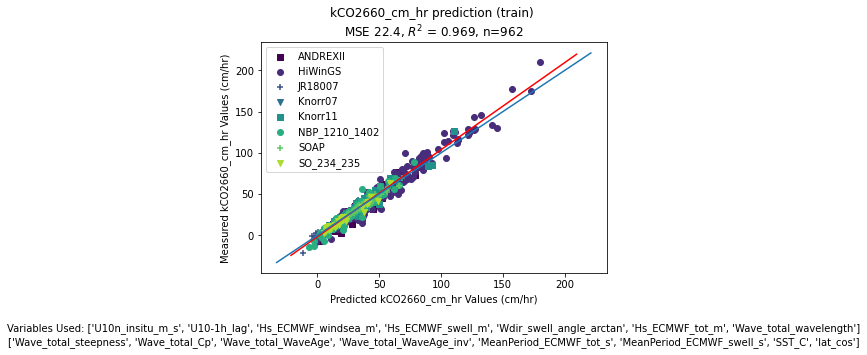

In [31]:
# Plot training data prediction model

Y_trpred = pd.DataFrame(y_scaler.inverse_transform(np.expand_dims(rf_reg.predict(x_train), axis=1)), columns=predictions)
Y_train = pd.DataFrame(y_scaler.inverse_transform(y_train), columns=predictions)
X_cruise = df.iloc[x_train.index].Cruise
num_Cruise = len(cruise_list)

f = plt.figure()
for idx,var in enumerate(y_train.columns):
    ax = plt.subplot(1, 1, idx+1)
    for idx,cruise in enumerate(cruise_list):
        Y_train_ = Y_train.loc[(X_cruise == cruise).values]
        Y_trpred_ = Y_trpred.loc[(X_cruise == cruise).values]
        marker = markers[idx%4]
        plt.scatter(Y_trpred_[var], Y_train_[var], marker=marker, color=cmap(idx/num_Cruise), label=cruise)
    z = np.polyfit(Y_trpred[var], Y_train[var], 1)
    p = np.poly1d(z)
    plt.plot(sorted(Y_train[var]), p(sorted(Y_train[var])), "r-")
    plt.plot(ax.get_xlim(), ax.get_xlim())
    MSE_score = sk.metrics.mean_squared_error(Y_train[var], Y_trpred[var])
    R2_score = sk.metrics.r2_score(Y_train[var], Y_trpred[var])
    plt.title(
        f"{var} prediction (train) \nMSE {MSE_score:.3}, $R^2$ = {R2_score:.3}, n={y_train.shape[0]}"
    )
    plt.xlabel(f'Predicted {var} Values ({var_units[var]})')
    plt.ylabel(f'Measured {var} Values ({var_units[var]})')


    plt.legend()
if len(predictors) > 7:
    f.text(.5, -0.1, f"Variables Used: {predictors[:7]}", ha="center", wrap=True)
    f.text(.5, -0.15, f"{predictors[7:]}", ha="center", wrap=True)
else:
    f.text(.5, -0.1, f"Variables Used: {predictors}", ha="center", wrap=True)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig(f'{fig_dir}/{var}_train_prediction.png', bbox_inches='tight')
plt.show()

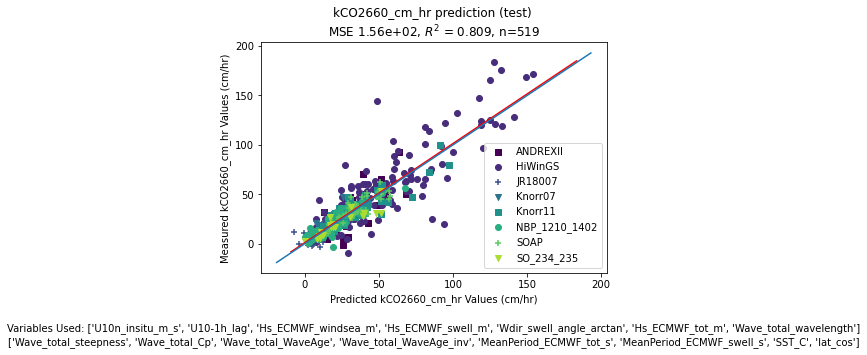

In [33]:
# Plot test data prediction model

X_cruise = df.iloc[x_test.index].Cruise
Y_pred = pd.DataFrame(y_scaler.inverse_transform(np.expand_dims(rf_reg.predict(x_test), axis=1)), columns=predictions)
Y_test = pd.DataFrame(y_scaler.inverse_transform(y_test), columns=predictions)


f = plt.figure()
for idx,var in enumerate(y_test.columns):
    ax = plt.subplot(1, 1, idx+1)
    for idx,cruise in enumerate(cruise_list):
        Y_test_ = Y_test.loc[(X_cruise == cruise).values]
        Y_pred_ = Y_pred.loc[(X_cruise == cruise).values]
        marker = markers[idx%4]
        plt.scatter(Y_pred_[var], Y_test_[var], marker=marker, color=cmap(idx/num_Cruise), label=cruise)
    z = np.polyfit(Y_pred[var], Y_test[var], 1)
    p = np.poly1d(z)
    plt.plot(sorted(Y_test[var]), p(sorted(Y_test[var])),  "r-")
    plt.plot(ax.get_xlim(), ax.get_xlim())
    MSE_score = sk.metrics.mean_squared_error(Y_test[var], Y_pred[var])
    R2_score = sk.metrics.r2_score(Y_test[var], Y_pred[var])
    plt.title(
        f"{var} prediction (test) \nMSE {MSE_score:.3}, $R^2$ = {R2_score:.3}, n={y_test.shape[0]}"
    )
    plt.xlabel(f'Predicted {var} Values ({var_units[var]})')
    plt.ylabel(f'Measured {var} Values ({var_units[var]})')
    plt.legend()
if len(predictors) > 7:
    f.text(.5, -0.1, f"Variables Used: {predictors[:7]}", ha="center", wrap=True)
    f.text(.5, -0.15, f"{predictors[7:]}", ha="center", wrap=True)
else:
    f.text(.5, -0.1, f"Variables Used: {predictors}", ha="center", wrap=True)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig(f'{fig_dir}/{var}_test_prediction.png', bbox_inches='tight')
plt.show()

In [34]:
# Combine data input output CSV for further analysis
df_train_out = df.iloc[x_train.index]
df_train_out['k_pred'] = Y_trpred.values
df_train_out['k_measure'] = Y_train.values
df_train_out['dataset'] = 'train'

df_test_out = df.iloc[x_test.index]
df_test_out['k_pred'] = Y_pred.values
df_test_out['k_measure'] = Y_test.values
df_test_out['dataset'] = 'test'

df_pred = pd.concat([df_train_out, df_test_out])
# df_pred[['k_pred','k_measure']]
df_pred.to_csv(f'{fig_dir}/Initial_Data.csv')

/tmp/ipykernel_60263/3635841807.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_out['k_pred'] = Y_trpred.values
/tmp/ipykernel_60263/3635841807.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_out['k_measure'] = Y_train.values
/tmp/ipykernel_60263/3635841807.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

# Evaluate on Separate Cruise Data

In [35]:
test_files = glob.glob('new_cruise_data/*.txt')
test_files

[]

In [ ]:
df_list = []
for file_load in test_files:
    print(file_load)#[5:-15])
    df_ = pd.read_csv(file_load,
                     parse_dates=[0],
                     skiprows=list(range(36)),
                     # header=1,
                     sep='\t',
                     )
    df_['Cruise'] = file_load[11:].split('_')[0]
    df_list.append(df_)

df_test = pd.concat(df_list, 
               axis=0, 
               ignore_index=True
              )
df_test['date-time'] = pd.to_datetime(df_test.YearMonthDay_TimeUTC, format='%Y%m%d%H%M.%f')
df_test = df_test.drop(columns=['YearMonthDay_TimeUTC'])

In [ ]:
col_rename = {
    # 'U10N (m/s)':'U10n_insitu_m_s',
    # 'SST (oC)':'SST_C',
    # 'latitude (-90~90)':'lat_deg',
    'date-time':'YearMonthDay_TimeUTC',
    # 'K660 (cm/hr)':'kCO2660_cm_hr'
}

df_test = df_test.rename(columns=col_rename)


In [ ]:
def create_features(df):
    
    rad_angle_diff = (df.Wdir_ECMWF_deg - df.Swell_dir_ECMWF_deg)*math.pi/180
    df['Wdir_swell_angle_arctan'] = np.arctan2(np.sin(rad_angle_diff), np.cos(rad_angle_diff))
    # wavelength from wave period in m
    df['Wave_total_wavelength'] = (9.81 * df.MeanPeriod_ECMWF_tot_s**2) / (2*np.pi)

    # steepness of waves: wave height/wavelength
    df['Wave_total_steepness'] = df.Hs_ECMWF_tot_m / df.Wave_total_wavelength

    # phase speed of waves. computed using deep water dispersion relationship
    df['Wave_total_Cp'] = np.sqrt(9.81/(2*np.pi/df.Wave_total_wavelength))  

    # wave age. larger for mature waves (>1 means fully developed); smaller for young waves
    df['Wave_total_WaveAge'] = df.Wave_total_Cp / df.U10n_insitu_m_s  

    #inverse wave age. might be easier to look at than wave age
    df['Wave_total_WaveAge_inv'] = 1/df.Wave_total_WaveAge    

    # cos of lat
    df['lat_cos'] = np.cos(df.lat_deg / 180 * 2*np.pi)
    
    
    df.sort_values(by='YearMonthDay_TimeUTC', inplace=True)
    df['T_lag'] = df['YearMonthDay_TimeUTC'] - df['YearMonthDay_TimeUTC'].shift()
    df['U10-1h_lag'] = df['U10n_insitu_m_s'].sort_values().shift()
    df.loc[df['T_lag'] != pd.Timedelta('1:00:00'), 'U10-1h_lag'] = np.nan
    
    return df

In [ ]:
df_test = create_features(df_test)
df_test_subset = df_test[predictors+predictions+['Cruise']].dropna()

df_test_subset

In [ ]:
X_cruise = df_test_subset.Cruise
cruise_list = X_cruise.unique()
X_test = x_scaler.transform(df_test_subset[predictors])

Y_pred = pd.DataFrame(y_scaler.inverse_transform(np.expand_dims(rf_reg.predict(X_test), axis=1)), columns=predictions)
Y_test = df_test_subset[predictions]

var_units = {'kCO2660_cm_hr':'cm/hr'}

f = plt.figure(figsize=(6,10))
var = 'kCO2660_cm_hr'
# for idx,var in enumerate(Y_test.columns):
    # ax = plt.subplot(1, 4, idx+1)
    # plt.plot(Y_test[var], Y_pred[var], marker="o", linestyle="")
for idx,cruise in enumerate(cruise_list):
    ax = plt.subplot(2, 1, idx+1)
    Y_test_ = Y_test.loc[(X_cruise == cruise).values]
    Y_pred_ = Y_pred.loc[(X_cruise == cruise).values]
    marker = markers[idx%4]
    plt.scatter(Y_pred_[var], Y_test_[var], marker=marker, color=cmap(idx/len(cruise_list)), label=cruise)
    z = np.polyfit(Y_pred_[var], Y_test_[var], 1)
    p = np.poly1d(z)
    plt.plot(sorted(Y_test_[var]), p(sorted(Y_test_[var])), "r-")
    # plt.xscale("log")
    # plt.yscale("log")
    plt.plot(ax.get_xlim(), ax.get_xlim())
    MSE_score = sk.metrics.mean_squared_error(Y_test_[var], Y_pred_[var])
    R2_score = sk.metrics.r2_score(Y_test_[var], Y_pred_[var])
    plt.title(
        f"{var} prediction {cruise} (test) \nMSE {MSE_score:.3}, $R^2$ = {R2_score:.3}, n={Y_test_.shape[0]}"
    )
    plt.xlabel(f'Predicted {var} Values ({var_units[var]})')
    plt.ylabel(f'Measured {var} Values ({var_units[var]})')
    plt.legend()#['Data Point', 'Linear Regression', 'Origin Line'])

if len(predictors) > 7:
    f.text(.5, -0.1, f"Variables Used: {predictors[:6]}", ha="center", wrap=True)
    f.text(.5, -0.15, f"{predictors[6:]}", ha="center", wrap=True)
else:
    f.text(.5, -0.1, f"Variables Used: {predictors}", ha="center", wrap=True)
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig(f'{fig_dir}/{var}_posttest_prediction.png', bbox_inches='tight')
plt.show()

In [ ]:
df_test_2 = df_test_subset#.iloc[x_train.index]
df_test_2['k_pred'] = Y_pred.values
df_test_2['k_measure'] = Y_test.values

# df_pred = pd.concat([df_train, df_test])
# df_test_2[['k_pred','k_measure']]

df_test_2.to_csv(f'{fig_dir}/Validation_Cruise_Data.csv')

# SHAP Analysis

In [ ]:
# !pip install shap
# import shap

In [ ]:
explainer = shap.Explainer(rf_reg)
shap_values = explainer(x_train)

In [ ]:
shap.plots.bar(shap_values, show=False)
plt.savefig(f'{fig_dir}/shap_feature_importance.png', bbox_inches='tight')
plt.show()

In [ ]:
svcopy = shap_values[0]
# svcopy.base_values = svcopy.base_values[0]
shap.plots.waterfall(svcopy)

In [ ]:
shap.summary_plot(shap_values[:, :], x_train.values, show=False)
plt.savefig(f'{fig_dir}/shap_plot.png')
plt.show()

In [ ]:
for sel_feat in shap_values.feature_names:
    shap.dependence_plot(sel_feat, 
                         shap_values=shap_values.values, 
                         features=x_train,
                         show=False,
                        )
    plt.savefig(f'{fig_dir}/shap_dependence_{sel_feat}.png')
    plt.show()

In [ ]:
features_display = x_test.columns
expected_value = explainer.expected_value
shap.decision_plot(expected_value, shap_values.values[:100,:], features_display, link='logit')
plt.savefig(f'{fig_dir}/shap_decision_plot.png')


In [ ]:
features_display = x_test.columns
expected_value = explainer.expected_value
shap.decision_plot(expected_value, shap_values.values[:,:], features_display, link='logit')
plt.savefig(f'{fig_dir}/shap_decision_plot_2.png')
